# Comparing tuned MC and ML models on Test and OOD sets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

import json

import torch
import torch.nn.functional as F

import time
from tqdm import tqdm

from model_utils import ModelWrapper, myDataLoader
from model_utils.braille_utils import num_to_bin_string, bin_to_num, num_to_bin, ml_to_mc, mc_to_ml, bin_to_string, string_to_bin
from model_utils.metrics import sigmoid_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, bitwise_F1,\
    macro_metrics, macro_recall, macro_precision, macro_F1, hamming_distances, mean_hamming_distance, mean_error_distance, \
    per_class_precision, per_class_recall, per_class_F1
from model_utils.augment import label_balance_resample, class_balance_resample, apply_augmentations
from model_utils.metrics import class_balance, label_correlations, class_frequency, between_label_imbalance, mean_mutual_information

In [3]:
np.__version__


'2.1.3'

In [4]:
sns.set_theme(style="darkgrid", font_scale=1.1)
PAL = sns.color_palette()

DATASETS = os.path.join('..', '..', 'Datasets', 'numpy_datasets')
MODEL_PATH = os.path.join('..', 'models')
PLOTS = os.path.join('..', 'plots')
EVAL = os.path.join('..', 'evals')
ML_LOGS = os.path.join('..', 'opt_logs', 'ml_tuning')
MC_LOGS = os.path.join('..', 'opt_logs', 'mc_tuning')

PAL

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [5]:
BLUE = "#1f77b4"
GREY = "#8F8F8F"
ORANGE = "#ffa35c"
RED = "#e50c3f"
YELLOW = "#f1c232"
DARK = "#0c343d"
LIGHT = "#efeae6"

In [6]:
CPAL = sns.color_palette([
    RED,
    ORANGE,
    BLUE,
    YELLOW,
    LIGHT,
    GREY,
    DARK
])

CPAL

[(0.8980392156862745, 0.047058823529411764, 0.24705882352941178),
 (1.0, 0.6392156862745098, 0.3607843137254902),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.9450980392156862, 0.7607843137254902, 0.19607843137254902),
 (0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.5607843137254902, 0.5607843137254902, 0.5607843137254902),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

In [7]:
RGB_NUM = 5

RPAL = sns.blend_palette([
    LIGHT,
    RED,
    DARK
], n_colors=RGB_NUM)

OPAL = sns.blend_palette([
    LIGHT,
    ORANGE,
    RED
], n_colors=RGB_NUM)

BPAL = sns.blend_palette([
    LIGHT,
    BLUE,
    DARK
], n_colors=RGB_NUM)

display(RPAL)
display(OPAL)
display(BPAL)

[(np.float64(0.9372549019607843),
  np.float64(0.9176470588235294),
  np.float64(0.9019607843137255)),
 (np.float64(0.9175701653210304),
  np.float64(0.4806459054209919),
  np.float64(0.5732256824298347)),
 (np.float64(0.8947020376778163),
  np.float64(0.04767397154940407),
  np.float64(0.24702806612841216)),
 (np.float64(0.4675432525951557),
  np.float64(0.12641291810841981),
  np.float64(0.24309111880046136)),
 (np.float64(0.047058823529411764),
  np.float64(0.20392156862745098),
  np.float64(0.23921568627450981))]

[(np.float64(0.9372549019607843),
  np.float64(0.9176470588235294),
  np.float64(0.9019607843137255)),
 (np.float64(0.9687504805843906),
  np.float64(0.7778854286812764),
  np.float64(0.6303114186851211)),
 (np.float64(0.999600153787005),
  np.float64(0.6368935024990388),
  np.float64(0.36033833141099575)),
 (np.float64(0.9484198385236448),
  np.float64(0.33965397923875434),
  np.float64(0.30325259515570935)),
 (np.float64(0.8980392156862745),
  np.float64(0.047058823529411764),
  np.float64(0.24705882352941178))]

[(np.float64(0.9372549019607843),
  np.float64(0.9176470588235294),
  np.float64(0.9019607843137255)),
 (np.float64(0.5278123798539023),
  np.float64(0.6912725874663591),
  np.float64(0.8035371011149558)),
 (np.float64(0.12127643214148404),
  np.float64(0.46563629373317955),
  np.float64(0.7040522875816994)),
 (np.float64(0.08387543252595156),
  np.float64(0.33374855824682814),
  np.float64(0.4698039215686275)),
 (np.float64(0.047058823529411764),
  np.float64(0.20392156862745098),
  np.float64(0.23921568627450981))]

In [8]:
PALS = [RPAL[1:], OPAL[1:], BPAL[1:]]
PALS[0]

[(np.float64(0.9175701653210304),
  np.float64(0.4806459054209919),
  np.float64(0.5732256824298347)),
 (np.float64(0.8947020376778163),
  np.float64(0.04767397154940407),
  np.float64(0.24702806612841216)),
 (np.float64(0.4675432525951557),
  np.float64(0.12641291810841981),
  np.float64(0.24309111880046136)),
 (np.float64(0.047058823529411764),
  np.float64(0.20392156862745098),
  np.float64(0.23921568627450981))]

### Figure fonts and styling

In [9]:
plt.rcParams["font.family"] = "Times New Roman" # or "Arial"
LBL_SIZE = 16
TICK_SIZE = 14
LBL_LARGE = 20

### Color Palette Alternatives

In [10]:
CONPAL = sns.blend_palette([
    RED,
    BLUE,
    DARK,
    BLUE,
    ORANGE
], n_colors=20)
CONPAL

[(np.float64(0.8980392156862745),
  np.float64(0.047058823529411764),
  np.float64(0.24705882352941178)),
 (np.float64(0.7397001153402538),
  np.float64(0.13262591311034216),
  np.float64(0.34062283737024224)),
 (np.float64(0.581361014994233),
  np.float64(0.2181930026912726),
  np.float64(0.4341868512110727)),
 (np.float64(0.4108419838523645),
  np.float64(0.31034217608612075),
  np.float64(0.5349480968858131)),
 (np.float64(0.25250288350634376),
  np.float64(0.3959092656670511),
  np.float64(0.6285121107266436)),
 (np.float64(0.11777008842752787),
  np.float64(0.45327181853133414),
  np.float64(0.6820915032679739)),
 (np.float64(0.1025759323337178),
  np.float64(0.3996924259900039),
  np.float64(0.5869281045751634)),
 (np.float64(0.08621299500192234),
  np.float64(0.3419915417147251),
  np.float64(0.48444444444444446)),
 (np.float64(0.07101883890811225),
  np.float64(0.28841214917339486),
  np.float64(0.389281045751634)),
 (np.float64(0.05465590157631679),
  np.float64(0.2307112648981161),
  np.float64(0.28679738562091506)),
 (np.float64(0.0546559015763168),
  np.float64(0.2307112648981161),
  np.float64(0.28679738562091506)),
 (np.float64(0.07101883890811223),
  np.float64(0.28841214917339475),
  np.float64(0.3892810457516338)),
 (np.float64(0.08621299500192234),
  np.float64(0.3419915417147251),
  np.float64(0.48444444444444446)),
 (np.float64(0.1025759323337178),
  np.float64(0.3996924259900039),
  np.float64(0.5869281045751634)),
 (np.float64(0.11777008842752787),
  np.float64(0.45327181853133414),
  np.float64(0.6820915032679739)),
 (np.float64(0.2696962706651288),
  np.float64(0.49576316801230297),
  np.float64(0.6476893502499039)),
 (np.float64(0.44882737408688966),
  np.float64(0.5309496347558631),
  np.float64(0.5773164167627836)),
 (np.float64(0.6417377931564783),
  np.float64(0.5688427527873894),
  np.float64(0.5015301806997309)),
 (np.float64(0.8208688965782391),
  np.float64(0.6040292195309496),
  np.float64(0.43115724721261056)),
 (np.float64(1.0),
  np.float64(0.6392156862745098),
  np.float64(0.3607843137254902))]

In [11]:
DIVPAL = sns.blend_palette([
    RED,
    LIGHT,
    YELLOW
], n_colors=20)
DIVPAL

[(np.float64(0.8980392156862745),
  np.float64(0.047058823529411764),
  np.float64(0.24705882352941178)),
 (np.float64(0.9020376778162246),
  np.float64(0.1358246828143022),
  np.float64(0.3138331410995771)),
 (np.float64(0.9060361399461746),
  np.float64(0.22459054209919263),
  np.float64(0.38060745866974244)),
 (np.float64(0.9103421760861208),
  np.float64(0.3201845444059977),
  np.float64(0.45251826220684355)),
 (np.float64(0.9143406382160708),
  np.float64(0.4089504036908881),
  np.float64(0.5192925797770088)),
 (np.float64(0.9186466743560169),
  np.float64(0.5045444059976932),
  np.float64(0.5912033833141099)),
 (np.float64(0.9226451364859669),
  np.float64(0.5933102652825837),
  np.float64(0.6579777008842753)),
 (np.float64(0.9269511726259131),
  np.float64(0.6889042675893888),
  np.float64(0.7298885044213764)),
 (np.float64(0.9309496347558631),
  np.float64(0.7776701268742792),
  np.float64(0.7966628219915417)),
 (np.float64(0.9352556708958093),
  np.float64(0.8732641291810841),
  np.float64(0.8685736255286428)),
 (np.float64(0.9376547481737794),
  np.float64(0.9096501345636293),
  np.float64(0.8659746251441753)),
 (np.float64(0.9385159554017686),
  np.float64(0.8924259900038447),
  np.float64(0.7884659746251443)),
 (np.float64(0.9393156478277586),
  np.float64(0.8764321414840446),
  np.float64(0.7164936562860438)),
 (np.float64(0.9401768550557478),
  np.float64(0.8592079969242599),
  np.float64(0.6389850057670127)),
 (np.float64(0.9409765474817378),
  np.float64(0.8432141484044597),
  np.float64(0.5670126874279123)),
 (np.float64(0.941837754709727),
  np.float64(0.825990003844675),
  np.float64(0.48950403690888117)),
 (np.float64(0.9426374471357171),
  np.float64(0.809996155324875),
  np.float64(0.41753171856978083)),
 (np.float64(0.9434986543637063),
  np.float64(0.7927720107650903),
  np.float64(0.3400230680507498)),
 (np.float64(0.9442983467896963),
  np.float64(0.7767781622452903),
  np.float64(0.2680507497116493)),
 (np.float64(0.9450980392156862),
  np.float64(0.7607843137254902),
  np.float64(0.19607843137254902))]

<Axes: >

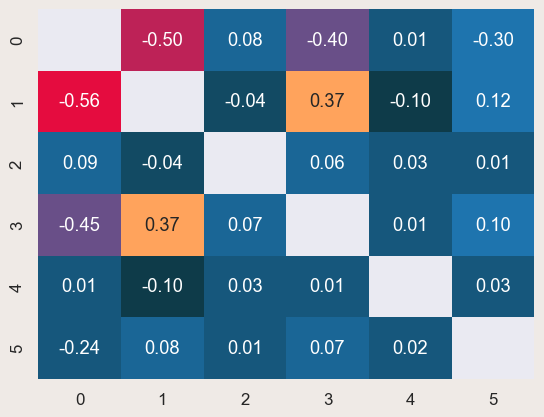

In [555]:

plt.figure(facecolor=LIGHT)
corr_m, corr_std, corr = label_correlations(train_Y)
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-0.6, vmax=0.4, cmap=CONPAL, cbar=False)

<Axes: >

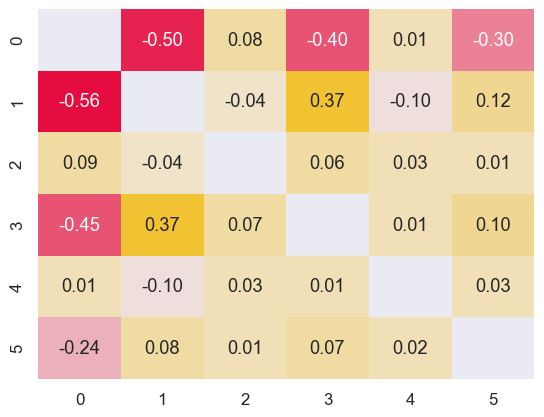

In [459]:

corr_m, corr_std, corr = label_correlations(train_Y)
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-0.6, vmax=0.4, cmap=DIVPAL, cbar=False)

## Data processing

In [17]:
angelina = os.path.join(DATASETS, "angelina.npz")
dsbi = os.path.join(DATASETS, "dsbi.npz")
abc = os.path.join(DATASETS, "abc.npz")
bcd = os.path.join(DATASETS, "bcd.npz")
b37 = os.path.join(DATASETS, "b37.npz")

data = np.load(angelina)
ood_dsbi = np.load(dsbi)
ood_abc = np.load(abc)
ood_bcd = np.load(bcd)
ood_b37 = np.load(b37)
print(data['train_x'].shape)
print(ood_dsbi['test_x'].shape)
print(ood_abc['test_x'].shape)
print(ood_bcd['test_x'].shape)
print(ood_b37['test_x'].shape)

(69267, 40, 30, 3)
(45627, 40, 30, 3)
(3168, 40, 30, 3)
(1560, 40, 30, 3)
(30608, 40, 30, 3)


In [18]:
train_X = data["train_x"] / 255.
train_Y = data["train_y"]


val_X = data["val_x"] / 255.
val_Y = data["val_y"]

test_X = data["test_x"] / 255.
test_Y = data["test_y"]

dsbi_X = ood_dsbi['test_x'] / 255.
dsbi_Y = ood_dsbi['test_y']

abc_X = ood_abc['test_x'] / 255.
abc_Y = ood_abc['test_y']

bcd_X = ood_bcd['test_x'] / 255.
bcd_Y = ood_bcd['test_y']

b37_X = ood_b37['test_x'] / 255.
b37_Y = ood_b37['test_y']

N, p = train_Y.shape

In [14]:
train_Y_cat = ml_to_mc(train_Y)
val_Y_cat = ml_to_mc(val_Y)
test_Y_cat = ml_to_mc(test_Y)
test_Y_str = bin_to_string(test_Y)

C = train_Y_cat.shape[1]

In [19]:

dsbi_Y_cat = ml_to_mc(dsbi_Y)
dsbi_Y_str = bin_to_string(dsbi_Y)

abc_Y_cat = ml_to_mc(abc_Y)
abc_Y_str = bin_to_string(abc_Y)

bcd_Y_cat = ml_to_mc(bcd_Y)
bcd_Y_str = bin_to_string(bcd_Y)

b37_Y_cat = ml_to_mc(b37_Y)
b37_Y_str = bin_to_string(b37_Y)

In [ ]:
del data, ood_dsbi, ood_abc, ood_bcd, ood_b37

## Model evaluation

In [21]:
param_space = {
    'lr': (0.0001, 0.02),
    'beta_1': (0.85, 0.95),
    'beta_2': (0.99, 0.9999),
    'l2': (0.0001, 0.03),
    'filters': (8, 64),
    'kernel_sz': (2,5),
    'dense_sz': (25, 150),
    'activs': (0, 2),
    'padding': (0, 1),
    'grey': (0, 1),
    'sqr': (0, 1)
}

param_names = [
    'Learning Rate', 'Beta1', 'Beta2', 'L2 Penalty',
    'Num Filters', 'Kernel Size', 'Dense Layer Size',
    'Activation function', 'Padding', 
    'Grey scaling', 'Square Input'
]

activations = {
    0: F.relu,
    1: F.tanh,
    2: F.leaky_relu
}

In [22]:
DEV = 'cpu'

NUM_CLASSES = 64
NUM_LABELS = 6

In [23]:
from matplotlib.patches import Patch, PathPatch, Rectangle, Shadow
from matplotlib.lines import Line2D
display(PAL)
display(CPAL)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

[(0.8980392156862745, 0.047058823529411764, 0.24705882352941178),
 (1.0, 0.6392156862745098, 0.3607843137254902),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.9450980392156862, 0.7607843137254902, 0.19607843137254902),
 (0.9372549019607843, 0.9176470588235294, 0.9019607843137255),
 (0.5607843137254902, 0.5607843137254902, 0.5607843137254902),
 (0.047058823529411764, 0.20392156862745098, 0.23921568627450981)]

### Theoretical Distribution of Braille Characters

In [139]:
all_braille_chars = pd.DataFrame(num_to_bin(np.arange(0, 2**6)), columns=[f'Dot {i}' for i in range(6)])
labels = all_braille_chars.index.values
all_braille_chars.head()

,Dot 0,Dot 1,Dot 2,Dot 3,Dot 4,Dot 5
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,1,1,0,0,0,0
4,0,0,1,0,0,0


In [118]:
from sklearn.metrics import pairwise_distances

braille_dists = pairwise_distances(all_braille_chars, metric='hamming')

In [133]:
from sklearn.manifold import MDS

embedding = MDS(n_components=3, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(braille_dists)
X_transformed.shape

(64, 3)

In [135]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=X_transformed[:, 0],
    y=X_transformed[:, 1],
    z=X_transformed[:, 2],
    mode='markers+text',
    marker=dict(size=8, color='red', symbol='square', opacity=0.5),
    text=labels,
    textposition='middle center'
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Factor 1',
        yaxis_title='Factor 2',
        zaxis_title='Factor 3',
        bgcolor='white'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)
fig.show()
# plt.figure()
# plt.margins(0.1)
# plt.axhline(0, color='gray')
# plt.axvline(0, color='gray')
# plt.xlabel('Factor 1')
# plt.ylabel('Factor 2')
# plt.scatter(X_transformed[:, 0], X_transformed[:, 1], s=150, marker='s', c='r', alpha=.5, linewidths=0)
# for label, x, y in zip(labels, X_transformed[:, 0], X_transformed[:, 1]):
#     plt.annotate(label, xy=(x, y), ha='center', va='center')
# plt.show()

In [136]:
all_braille_chars.iloc[[42,43,46,47]]

,Dot 0,Dot 1,Dot 2,Dot 3,Dot 4,Dot 5
42,0,1,0,1,0,1
43,1,1,0,1,0,1
46,0,1,1,1,0,1
47,1,1,1,1,0,1


### Model loading

In [24]:
import sys

In [25]:
base_ml_model = ModelWrapper(dev=DEV)
base_ml_model.load(os.path.join(MODEL_PATH, 'base_ml_model_v2'))

base_mc_model = ModelWrapper(dev=DEV)
base_mc_model.load(os.path.join(MODEL_PATH, 'base_mc_model_v2'))

In [26]:
lb_ml_model = ModelWrapper(dev=DEV)
lb_ml_model.load(os.path.join(MODEL_PATH, 'lb_ml_model'))

lb_mc_model = ModelWrapper(dev=DEV)
lb_mc_model.load(os.path.join(MODEL_PATH, 'lb_mc_model'))

In [27]:
cb_ml_model = ModelWrapper(dev=DEV)
cb_ml_model.load(os.path.join(MODEL_PATH, 'cb_ml_model'))

cb_mc_model = ModelWrapper(dev=DEV)
cb_mc_model.load(os.path.join(MODEL_PATH, 'cb_mc_model'))

In [28]:
ab_ml_model = ModelWrapper(dev=DEV)
ab_ml_model.load(os.path.join(MODEL_PATH, 'ab_ml_model'))

ab_mc_model = ModelWrapper(dev=DEV)
ab_mc_model.load(os.path.join(MODEL_PATH, 'ab_mc_model'))

In [29]:
# Model lists and model name lists
models = [base_mc_model, base_ml_model,
          cb_mc_model, cb_ml_model,
          lb_mc_model, lb_ml_model,
          ab_mc_model, ab_ml_model]
model_names = ['Base MC', 'Base ML',
               'CB MC', 'CB ML',
               'LB MC', 'LB ML',
               'AB MC', 'AB ML']


base_ml_model.param_dict

{'in_size': [32, 32, 3],
 'filts': 24,
 'kerns': 5,
 'pad': 1,
 'out_size': 6,
 'activ': 'tanh',
 'dense_sz': 115,
 'beta_2': 0.9999,
 'beta_1': 0.8702337788234192,
 'l2': 0.0005,
 'lr': 0.0006905246895851634,
 'grey_scaled': 0,
 'square_in': 1}

In [24]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [25]:
from torchsummary import summary
summary(base_ml_model.model, input_size=(40, 30, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 30, 30]           1,824
            Conv2d-2           [-1, 24, 28, 28]          14,424
         MaxPool2d-3           [-1, 24, 14, 14]               0
            Conv2d-4           [-1, 48, 12, 12]          28,848
            Conv2d-5           [-1, 48, 10, 10]          57,648
         MaxPool2d-6             [-1, 48, 5, 5]               0
            Linear-7                  [-1, 115]         138,115
            Linear-8                    [-1, 6]             696
Total params: 241,555
Trainable params: 241,555
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 0.92
Estimated Total Size (MB): 1.38
----------------------------------------------------------------


In [26]:
base_ml_model.model

ConvModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1200, out_features=115, bias=True)
  (fc2): Linear(in_features=115, out_features=6, bias=True)
)

#### ID Test Predictions

In [27]:
ml_test_loader = myDataLoader(test_X, test_Y, batch_sz=2048, dev=DEV)
mc_test_loader = myDataLoader(test_X, test_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'true_label': test_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    if i % 2 == 0:
        preds = model.predict(mc_test_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_test_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

In [29]:
predictions.to_csv(os.path.join(EVAL, 'all_cbr_test_predictions.csv'), index=False)
# predictions = pd.read_csv(os.path.join(EVAL, 'all_cbr_test_predictions.csv'), dtype=str)

In [28]:
predictions.head()

,true_label,Base MC,Base ML,CB MC,CB ML,LB MC,LB ML,AB MC,AB ML
0,011001,011001,011001,011001,011001,011001,011001,011001,011001
1,101010,101010,101010,101010,101010,101010,101010,101010,101010
2,111010,111010,111010,111010,111010,111010,111010,111010,111010
3,111010,111010,111010,111010,111010,111010,111010,111010,111010
4,011001,011001,011001,011001,011001,011001,011001,011001,001001


In [30]:
correct_predictions = predictions.apply(
    lambda row: row == row['true_label'],
    axis=1
).drop(columns='true_label')
correct_predictions.head()

,Base MC,Base ML,CB MC,CB ML,LB MC,LB ML,AB MC,AB ML
0,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,False


In [31]:
all_correct = correct_predictions[correct_predictions.all(axis=1)].index
all_wrong = correct_predictions[~correct_predictions.any(axis=1)].index

In [32]:
print(f"{all_correct.shape[0]} samples correctly classified by ALL models.")
display(all_correct.tolist()[:5])

print(f"{all_wrong.shape[0]} samples correctly classified by NONE of the models.")
display(all_wrong.tolist()[:5])

11109 samples correctly classified by ALL models.


[0, 1, 2, 3, 5]

17 samples correctly classified by NONE of the models.


[1146, 1980, 3159, 3463, 4384]

#### OOD Test Predictions

In [ ]:
ml_ood_loader = myDataLoader(dsbi_X, dsbi_Y, batch_sz=2048, dev=DEV)
mc_ood_loader = myDataLoader(dsbi_X, dsbi_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'true_label': dsbi_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    print(f"Obtaining predictions for model {model_name}...")
    if i % 2 == 0:
        preds = model.predict(mc_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

predictions.to_csv(os.path.join(EVAL, 'all_cbr_ood_predictions.csv'), index=False)

Obtaining predictions for model Base MC...
Obtaining predictions for model Base ML...
Obtaining predictions for model CB MC...
Obtaining predictions for model CB ML...
Obtaining predictions for model LB MC...
Obtaining predictions for model LB ML...
Obtaining predictions for model AB MC...
Obtaining predictions for model AB ML...


In [ ]:
# predictions = pd.read_csv(os.path.join(EVAL, 'all_cbr_ood_predictions.csv'), dtype=str)

In [34]:
predictions.head()

,true_label,Base MC,Base ML,CB MC,CB ML,LB MC,LB ML,AB MC,AB ML
0,010100,010100,010100,010100,010100,010100,010100,010100,010100
1,101000,101000,101000,101000,101000,101000,101000,101000,101000
2,001100,101100,001100,001100,001100,001100,001100,001100,001100
3,011000,011100,011000,011000,011000,011000,011000,011000,011000
4,010001,010001,010001,010001,010001,010000,010001,010001,010001


In [30]:
ml_ood_loader = myDataLoader(abc_X, abc_Y, batch_sz=2048, dev=DEV)
mc_ood_loader = myDataLoader(abc_X, abc_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'true_label': abc_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    print(f"Obtaining predictions for model {model_name}...")
    if i % 2 == 0:
        preds = model.predict(mc_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

predictions.to_csv(os.path.join(EVAL, 'all_cbr_abc_ood_predictions.csv'), index=False)

Obtaining predictions for model Base MC...
Obtaining predictions for model Base ML...
Obtaining predictions for model CB MC...
Obtaining predictions for model CB ML...
Obtaining predictions for model LB MC...
Obtaining predictions for model LB ML...
Obtaining predictions for model AB MC...
Obtaining predictions for model AB ML...


In [31]:
ml_ood_loader = myDataLoader(bcd_X, bcd_Y, batch_sz=2048, dev=DEV)
mc_ood_loader = myDataLoader(bcd_X, bcd_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'true_label': bcd_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    print(f"Obtaining predictions for model {model_name}...")
    if i % 2 == 0:
        preds = model.predict(mc_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

predictions.to_csv(os.path.join(EVAL, 'all_cbr_bcd_ood_predictions.csv'), index=False)

Obtaining predictions for model Base MC...
Obtaining predictions for model Base ML...
Obtaining predictions for model CB MC...
Obtaining predictions for model CB ML...
Obtaining predictions for model LB MC...
Obtaining predictions for model LB ML...
Obtaining predictions for model AB MC...
Obtaining predictions for model AB ML...


In [32]:
ml_ood_loader = myDataLoader(b37_X, b37_Y, batch_sz=2048, dev=DEV)
mc_ood_loader = myDataLoader(b37_X, b37_Y_cat, batch_sz=2048, dev=DEV)
predictions = pd.DataFrame({'true_label': b37_Y_str})

for i, (model, model_name) in enumerate(zip(models, model_names)):
    print(f"Obtaining predictions for model {model_name}...")
    if i % 2 == 0:
        preds = model.predict(mc_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(num_to_bin(preds))
    else:
        preds = model.predict(ml_ood_loader, verbose=1)
        predictions[model_name] = bin_to_string(preds)

predictions.to_csv(os.path.join(EVAL, 'all_cbr_b37_ood_predictions.csv'), index=False)

Obtaining predictions for model Base MC...
Obtaining predictions for model Base ML...
Obtaining predictions for model CB MC...
Obtaining predictions for model CB ML...
Obtaining predictions for model LB MC...
Obtaining predictions for model LB ML...
Obtaining predictions for model AB MC...
Obtaining predictions for model AB ML...


### Model Saliencies

In [ ]:
def compute_max_saliency(model, sample_tensor):
    model.eval()
    sample_tensor.requires_grad_()
    scores = model(sample_tensor)
    score_max_idx = scores.argmax()
    score_max = scores[0, score_max_idx]

    score_max.backward()
    max_saliency, _ = torch.max(sample_tensor.grad.data.abs(),dim=3)
    
    return max_saliency[0]

def compute_target_saliency(model, sample_tensor, target):
    model.eval()
    sample_tensor.requires_grad_()
    scores = model(sample_tensor)
    score_target = scores[0, target]

    score_target.backward()
    target_saliency, _ = torch.max(sample_tensor.grad.data.abs(),dim=3)
    
    return target_saliency[0]

In [125]:
def investigate_class_saliencies(model, sample_tensor, true_class):
    fig, axes = plt.subplots(4, 16, figsize=(30,10))

    saliencies = []
    for i in range(NUM_CLASSES):
        ax = axes[i // 16, i % 16]
        target_saliency = compute_target_saliency(model, sample_tensor, i)
        saliencies.append(target_saliency)

        ax.imshow(target_saliency, cmap=plt.cm.hot)
        true_label_str = " (Target)" if i == true_class else ""
        fw = 'bold' if i == true_class else 'normal'
        ax.set_title(f"Class {i}{true_label_str}", fontweight=fw)
        ax.axis('off')
    
    mean_saliency = np.mean(saliencies, axis=0)
    return fig, mean_saliency

In [127]:
def investigate_label_saliencies(model, sample_tensor, true_label):
    fig, axes = plt.subplots(3, 2, figsize=(7,15))

    saliencies = []
    for i in range(NUM_LABELS):
        ax = axes[i % 3, i // 3]
        target_saliency = compute_target_saliency(model, sample_tensor, i)
        saliencies.append(target_saliency)

        ax.imshow(target_saliency, cmap=plt.cm.hot)
        fw = 'bold' if int(true_label[i]) == 1 else 'normal'
        ax.set_title(f"Label {i+1} ({true_label[i]})", fontweight=fw)
        ax.axis('off')
    
    mean_saliency = np.mean(saliencies, axis=0)
    return fig, mean_saliency

In [126]:
gs, bs = 1, 622

good_sample = test_X[gs]
good_sample_tensor = torch.Tensor(np.array([good_sample]))
good_sample_class = test_Y_cat[gs].argmax()
good_sample_ml = test_Y[gs]

bad_sample = test_X[bs]
bad_sample_tensor = torch.Tensor(np.array([bad_sample]))
bad_sample_class = test_Y_cat[bs].argmax()
bad_sample_ml = test_Y[bs]

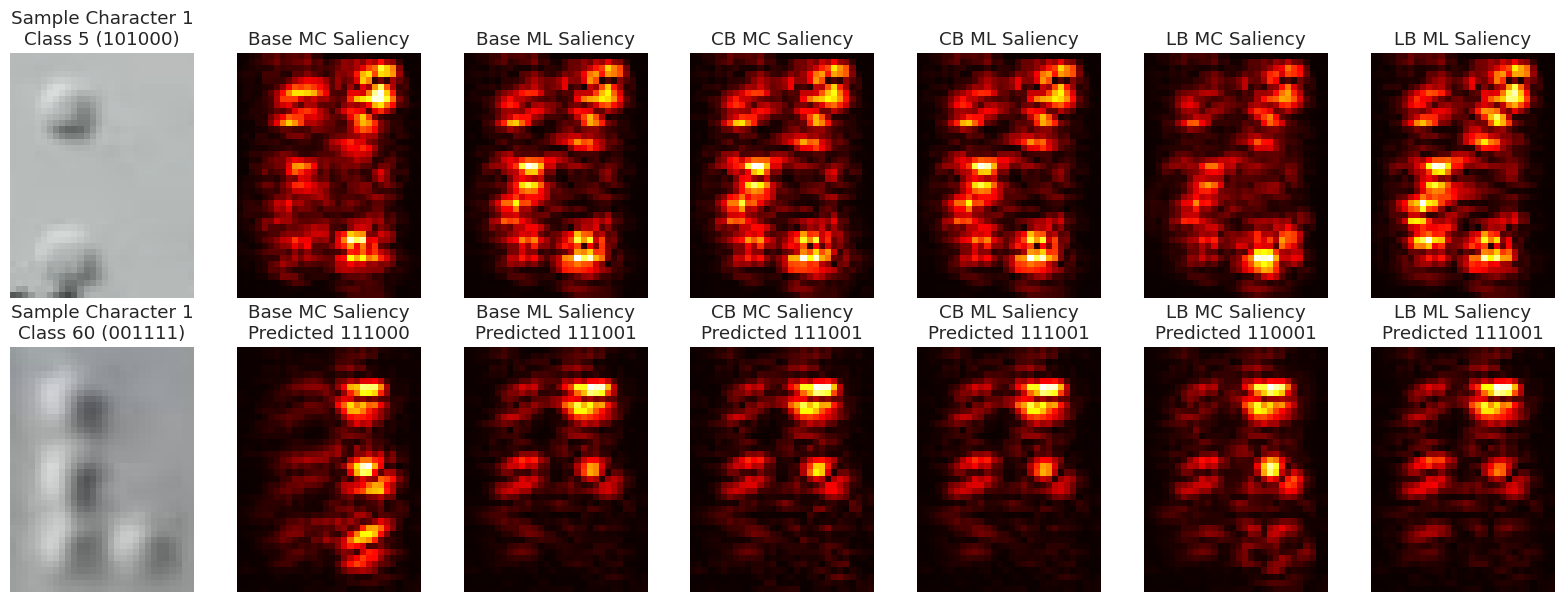

In [148]:
m_fig, m_axes = plt.subplots(2, 7, figsize=(20, 7))
plt.ioff()

m_axes[0, 0].imshow(good_sample)
m_axes[0, 0].set_title(f"Sample Character 1\nClass {good_sample_class} ({bin_to_string(good_sample_ml.astype(str).tolist())})")
m_axes[0, 0].axis('off')

m_axes[1, 0].imshow(bad_sample)
m_axes[1, 0].set_title(f"Sample Character 1\nClass {bad_sample_class} ({bin_to_string(bad_sample_ml.astype(str).tolist())})")
m_axes[1, 0].axis('off')

for m, (model, model_name) in enumerate(zip(models, model_names)):
    model_bs_pred_ml = predictions.loc[bs, model_name]
    model_bs_pred = bin_to_num(np.array(list(model_bs_pred_ml), dtype=int))

    if m % 2 == 0: # MC
        gfig, gsaliency = investigate_class_saliencies(model.model, good_sample_tensor, good_sample_class)
        bfig, bsaliency = investigate_class_saliencies(model.model, bad_sample_tensor, bad_sample_class)

    else: # ML
        gfig, gsaliency = investigate_label_saliencies(model.model, good_sample_tensor, good_sample_ml)
        bfig, bsaliency = investigate_label_saliencies(model.model, bad_sample_tensor, bad_sample_ml)

    gfig.savefig(os.path.join(PLOTS, f"saliencies_per_target_{model_name.lower().replace(' ', '_')}_good_sample.png"), bbox_inches='tight')
    bfig.savefig(os.path.join(PLOTS, f"saliencies_per_target_{model_name.lower().replace(' ', '_')}_bad_sample.png"), bbox_inches='tight')
    plt.close(gfig)
    plt.close(bfig)

    m_axes[0, m+1].imshow(gsaliency, cmap=plt.cm.hot)
    m_axes[0, m+1].set_title(f"{model_name} Saliency")
    m_axes[0, m+1].axis('off')

    m_axes[1, m+1].imshow(bsaliency, cmap=plt.cm.hot)
    m_axes[1, m+1].set_title(f"{model_name} Saliency\nPredicted {model_bs_pred_ml}")
    m_axes[1, m+1].axis('off')
m_fig.show()


In [ ]:

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import backend as BK


In [ ]:
saliency_idx = [1, 111, 608, 5, 1129, 59, 70]
saliency_samples = []
for i, idx in enumerate(saliency_idx):
    sample = os_test_X[idx]
    if i == 3:
        sample = np.flip(sample, 1)
    saliency_samples.append(sample)
saliency_samples = np.array(saliency_samples)

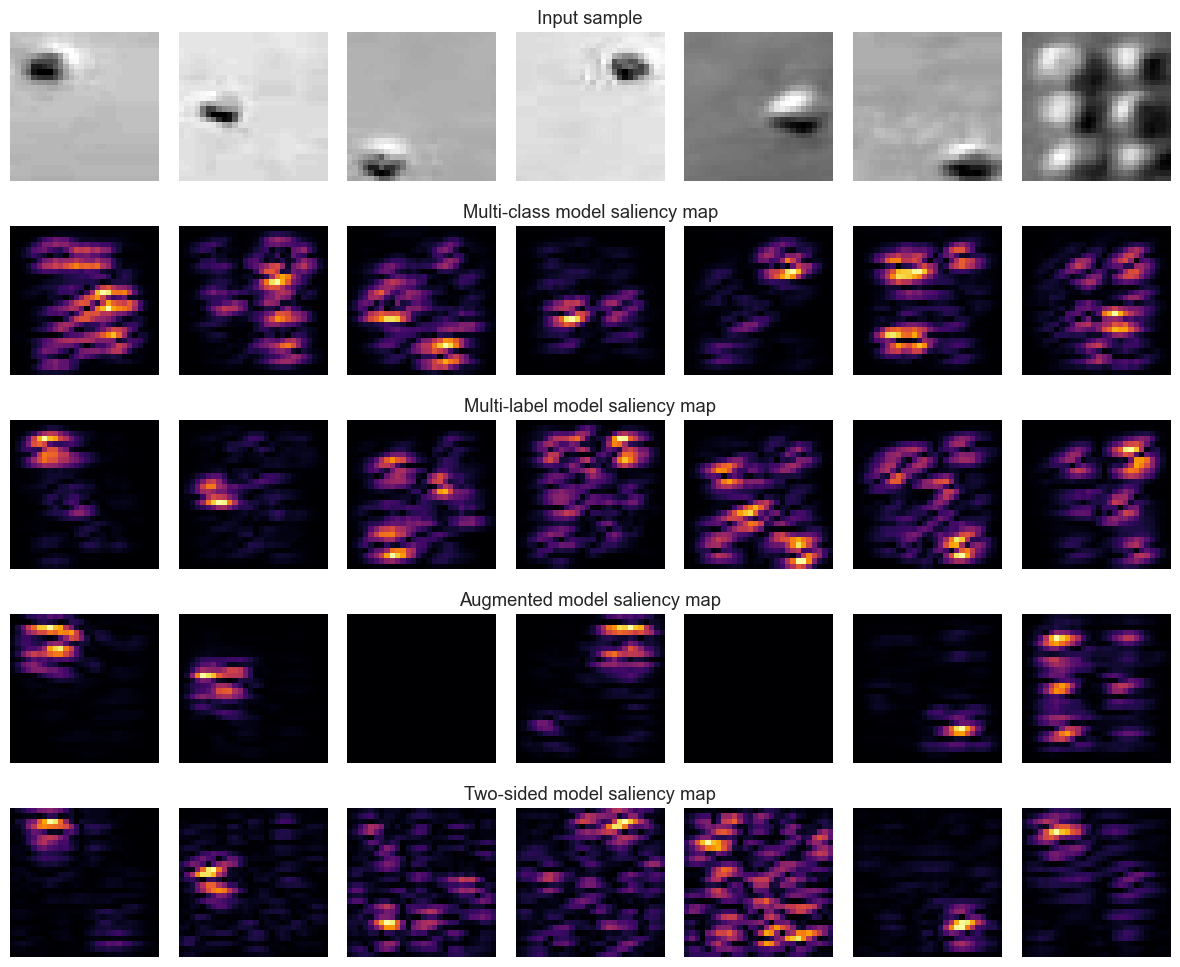

In [ ]:
def compute_saliency(model, img_array, full=False):
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        top_prediction = tf.argmax(predictions[0])
        output = predictions[:, top_prediction]

    if full:
        gradient = tape.gradient(predictions, img_array)
    else:
        gradient = tape.gradient(output, img_array)
    saliency = tf.abs(gradient[0])
    return saliency 

saliencies = []
for i, img in enumerate(saliency_samples):
    img_array = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)
    sal_i = []
    for m, model in enumerate([mc_model, ml_model, aug_model, ts_model]):
        sal_i.append(compute_saliency(model, img_array, m > 0 and i == 6))
    saliencies.append(sal_i)

fig, axes = plt.subplots(5, 7, figsize=(12,10))
for i in range(7):
    axes[0,i].imshow(saliency_samples[i])
    axes[0,i].axis("off")
    for m in range(4):
        axes[m+1,i].imshow(saliencies[i][m], cmap='inferno')
        axes[m+1,i].axis('off')
        
axes[0,3].set_title("Input sample")
axes[1,3].set_title("Multi-class model saliency map")
axes[2,3].set_title("Multi-label model saliency map")
axes[3,3].set_title("Augmented model saliency map")
axes[4,3].set_title("Two-sided model saliency map")

plt.tight_layout()


### Model Concept Vector Visualisations

In [ ]:
# As per model_comparison_CBR
minority_classes = [28, 4, 35, 8, 32, 48, 55, 6, 44, 12, 39, 16, 20, 61, 57, 59, 41]
majority_classes = [21, 1, 17, 10, 30, 29, 14, 7, 5, 23, 58, 25, 13, 37, 15, 2, 50]

SIZE_PER_REST = 5
SUB_SIZE = SIZE_PER_REST * len(majority_classes+minority_classes) # 170

In [197]:
min_maj_classes = minority_classes+majority_classes
min_maj_labels = num_to_bin(min_maj_classes)
classes_with_lbl = min_maj_labels.sum(axis=0)
classes_without_lbl = len(min_maj_classes) - min_maj_labels.sum(axis=0)

min_maj_labels_dict = {
    c: min_maj_labels[ci] for ci, c in enumerate(min_maj_classes)
}
min_maj_labels_dict

{28: array([0, 0, 1, 1, 1, 0]),
 4: array([0, 0, 1, 0, 0, 0]),
 35: array([1, 1, 0, 0, 0, 1]),
 8: array([0, 0, 0, 1, 0, 0]),
 32: array([0, 0, 0, 0, 0, 1]),
 48: array([0, 0, 0, 0, 1, 1]),
 55: array([1, 1, 1, 0, 1, 1]),
 6: array([0, 1, 1, 0, 0, 0]),
 44: array([0, 0, 1, 1, 0, 1]),
 12: array([0, 0, 1, 1, 0, 0]),
 39: array([1, 1, 1, 0, 0, 1]),
 16: array([0, 0, 0, 0, 1, 0]),
 20: array([0, 0, 1, 0, 1, 0]),
 61: array([1, 0, 1, 1, 1, 1]),
 57: array([1, 0, 0, 1, 1, 1]),
 59: array([1, 1, 0, 1, 1, 1]),
 41: array([1, 0, 0, 1, 0, 1]),
 21: array([1, 0, 1, 0, 1, 0]),
 1: array([1, 0, 0, 0, 0, 0]),
 17: array([1, 0, 0, 0, 1, 0]),
 10: array([0, 1, 0, 1, 0, 0]),
 30: array([0, 1, 1, 1, 1, 0]),
 29: array([1, 0, 1, 1, 1, 0]),
 14: array([0, 1, 1, 1, 0, 0]),
 7: array([1, 1, 1, 0, 0, 0]),
 5: array([1, 0, 1, 0, 0, 0]),
 23: array([1, 1, 1, 0, 1, 0]),
 58: array([0, 1, 0, 1, 1, 1]),
 25: array([1, 0, 0, 1, 1, 0]),
 13: array([1, 0, 1, 1, 0, 0]),
 37: array([1, 0, 1, 0, 0, 1]),
 15: array([1,

In [181]:
classes_with_lbl, classes_without_lbl

(array([18, 14, 19, 16, 16, 13]), array([16, 20, 15, 18, 18, 21]))

In [182]:
samples_with_lbl = SUB_SIZE * classes_with_lbl
samples_without_lbl = SUB_SIZE * classes_without_lbl
samples_with_lbl, samples_without_lbl

(array([3060, 2380, 3230, 2720, 2720, 2210]),
 array([2720, 3400, 2550, 3060, 3060, 3570]))

In [195]:
LABEL_SAMPLES = 2000
pos_samples_per_class = np.floor(LABEL_SAMPLES / classes_with_lbl).astype(int)
neg_samples_per_class = np.floor(LABEL_SAMPLES / classes_without_lbl).astype(int)

pos_samples_per_class, neg_samples_per_class

(array([111, 142, 105, 125, 125, 153]), array([125, 100, 133, 111, 111,  95]))

In [234]:
from PIL import Image
import numpy as np
import glob

negative_examples_path = os.path.join('..', '..', 'Datasets', 'negative_samples')
negative_examples_numpy = os.path.join('..', '..', 'Datasets', 'numpy_datasets', 'neg_samples.npz')
# Get list of .png files
png_files = sorted(glob.glob(os.path.join(negative_examples_path, '*.png')))

# Read and process images
negative_examples = []
for file in png_files[:5]:
    img = Image.open(file).convert('RGB').resize((30, 40))
    negative_examples.append(np.array(img))

negative_examples = np.stack(negative_examples, axis=0)
negative_examples = negative_examples / 255.
np.savez(negative_examples_numpy, negative_examples=negative_examples)


neg_ids = [f'Neg{i}' for i in range(SIZE_PER_REST)]

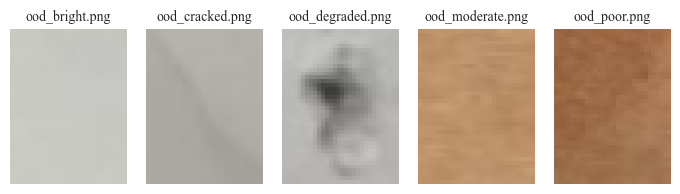

In [210]:
fig, axes = plt.subplots(1, 5, figsize=(7, 3))
for i in range(5):
    axes[i].imshow(negative_examples[i])
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(png_files[i]), fontsize=10)
plt.tight_layout()
plt.show()

In [217]:
# Subset of ID Test set

test_samples_per_class = {}
all_test_samples = []

for extr_class in min_maj_classes:
    test_samples = np.where(ood_Y_cat[:, extr_class])[0][:SUB_SIZE]
    test_samples_per_class[extr_class] = test_samples
    all_test_samples = all_test_samples + list(test_samples)
    
test_samples_X = ood_X[all_test_samples]
test_samples_Y = ood_Y[all_test_samples]
test_samples_Y_cat = ood_Y_cat[all_test_samples]

test_samples_X.shape

(5780, 40, 30, 3)

In [199]:
pos_samples_per_class

array([111, 142, 105, 125, 125, 153])

In [275]:
test_samples_per_label = {
    l: {
        'positive': [],
        'negative': []
    } for l in range(NUM_LABELS)
}

for l in range(NUM_LABELS):
    for c in test_samples_per_class.keys():
        if min_maj_labels_dict[c][l]:
            test_samples_per_label[l]['positive'] = test_samples_per_label[l]['positive'] + list(test_samples_per_class[c][:pos_samples_per_class[l]])
        else:
            test_samples_per_label[l]['negative'] = test_samples_per_label[l]['negative'] + list(test_samples_per_class[c][:neg_samples_per_class[l]])
test_samples_per_label

{0: {'positive': [np.int64(60),
   np.int64(212),
   np.int64(346),
   np.int64(552),
   np.int64(649),
   np.int64(763),
   np.int64(852),
   np.int64(860),
   np.int64(1001),
   np.int64(1322),
   np.int64(1383),
   np.int64(1473),
   np.int64(1512),
   np.int64(1618),
   np.int64(1659),
   np.int64(1690),
   np.int64(1713),
   np.int64(1751),
   np.int64(1759),
   np.int64(1774),
   np.int64(1848),
   np.int64(2158),
   np.int64(2225),
   np.int64(2309),
   np.int64(2631),
   np.int64(2833),
   np.int64(2945),
   np.int64(2947),
   np.int64(3152),
   np.int64(3155),
   np.int64(3216),
   np.int64(3269),
   np.int64(3417),
   np.int64(3456),
   np.int64(3532),
   np.int64(3534),
   np.int64(3605),
   np.int64(3825),
   np.int64(3855),
   np.int64(3863),
   np.int64(4160),
   np.int64(4221),
   np.int64(4303),
   np.int64(4350),
   np.int64(4370),
   np.int64(4629),
   np.int64(4668),
   np.int64(4688),
   np.int64(4744),
   np.int64(4746),
   np.int64(4890),
   np.int64(4974),
   np.

In [206]:
{
    l: {
        'p': len(test_samples_per_label[l]['positive']),
        'n': len(test_samples_per_label[l]['negative'])
    } for l in range(NUM_LABELS)
}

{0: {'p': 1998, 'n': 2000},
 1: {'p': 1988, 'n': 2000},
 2: {'p': 1995, 'n': 1995},
 3: {'p': 2000, 'n': 1998},
 4: {'p': 2000, 'n': 1998},
 5: {'p': 1989, 'n': 1995}}

In [258]:
_, base_mc_neg_act = base_mc_model.model.forward_with_activs(torch.Tensor(negative_examples))
base_mc_class_act = {}
for c in min_maj_classes:
    _, acts = base_mc_model.model.forward_with_activs(torch.Tensor(ood_X[test_samples_per_class[c]]))
    base_mc_class_act[c] = {
    'Conv1 Flat': torch.flatten(acts['conv1'], 1).detach().numpy(),
    'Conv2 Flat': torch.flatten(acts['conv2'], 1).detach().numpy(),
    'Conv3 Flat': torch.flatten(acts['conv3'], 1).detach().numpy(),
    'Conv4 Flat': torch.flatten(acts['conv4'], 1).detach().numpy(),
    'FC1': acts['fc1'].detach().numpy()}
base_mc_class_act['neg'] = {
    'Conv1 Flat': torch.flatten(base_mc_neg_act['conv1'], 1).detach().numpy(),
    'Conv2 Flat': torch.flatten(base_mc_neg_act['conv2'], 1).detach().numpy(),
    'Conv3 Flat': torch.flatten(base_mc_neg_act['conv3'], 1).detach().numpy(),
    'Conv4 Flat': torch.flatten(base_mc_neg_act['conv4'], 1).detach().numpy(),
    'FC1': base_mc_neg_act['fc1'].detach().numpy()}

In [259]:
_, base_ml_neg_act = base_ml_model.model.forward_with_activs(torch.Tensor(negative_examples))
base_ml_class_act = {}
for c in min_maj_classes:
    _, acts = base_ml_model.model.forward_with_activs(torch.Tensor(ood_X[test_samples_per_class[c]]))
    base_ml_class_act[c] = {
    'Conv1 Flat': torch.flatten(acts['conv1'], 1).detach().numpy(),
    'Conv2 Flat': torch.flatten(acts['conv2'], 1).detach().numpy(),
    'Conv3 Flat': torch.flatten(acts['conv3'], 1).detach().numpy(),
    'Conv4 Flat': torch.flatten(acts['conv4'], 1).detach().numpy(),
    'FC1': acts['fc1'].detach().numpy()}
base_ml_class_act['neg'] = {
    'Conv1 Flat': torch.flatten(base_ml_neg_act['conv1'], 1).detach().numpy(),
    'Conv2 Flat': torch.flatten(base_ml_neg_act['conv2'], 1).detach().numpy(),
    'Conv3 Flat': torch.flatten(base_ml_neg_act['conv3'], 1).detach().numpy(),
    'Conv4 Flat': torch.flatten(base_ml_neg_act['conv4'], 1).detach().numpy(),
    'FC1': base_ml_neg_act['fc1'].detach().numpy()}

In [261]:
from model_utils import FastCAVClassifier

In [266]:
class_concept = 28
layer = 'Conv1 Flat'
pos_samples = base_mc_class_act[class_concept][layer]
neg_samples = np.vstack([
    base_mc_class_act[other_class][layer][:SIZE_PER_REST] for other_class in min_maj_classes if other_class != class_concept
])
neg_samples = np.vstack([neg_samples, base_mc_class_act['neg'][layer]])

print(pos_samples.shape, neg_samples.shape)

cav_X = np.vstack([pos_samples, neg_samples])
cav_Y = np.hstack([np.ones(SUB_SIZE), np.zeros(SUB_SIZE)])

print(cav_X.shape, cav_Y.shape)
fast_cav = FastCAVClassifier()

fast_cav.fit(cav_X, cav_Y)

(170, 68096) (170, 68096)
(340, 68096) (340,)


In [269]:
fast_cav.intercept_, fast_cav.coef_.shape, fast_cav.mean.shape

(tensor([[-22.3564]]), torch.Size([1, 68096]), torch.Size([68096]))

In [270]:
test_samples_per_label

{0: {'positive': [np.int64(60),
   np.int64(212),
   np.int64(346),
   np.int64(552),
   np.int64(649),
   np.int64(763),
   np.int64(852),
   np.int64(860),
   np.int64(1001),
   np.int64(1322),
   np.int64(1383),
   np.int64(1473),
   np.int64(1512),
   np.int64(1618),
   np.int64(1659),
   np.int64(1690),
   np.int64(1713),
   np.int64(1751),
   np.int64(1759),
   np.int64(1774),
   np.int64(1848),
   np.int64(2158),
   np.int64(2225),
   np.int64(2309),
   np.int64(2631),
   np.int64(2833),
   np.int64(2945),
   np.int64(2947),
   np.int64(3152),
   np.int64(3155),
   np.int64(3216),
   np.int64(3269),
   np.int64(3417),
   np.int64(3456),
   np.int64(3532),
   np.int64(3534),
   np.int64(3605),
   np.int64(3825),
   np.int64(3855),
   np.int64(3863),
   np.int64(4160),
   np.int64(4221),
   np.int64(4303),
   np.int64(4350),
   np.int64(4370),
   np.int64(4629),
   np.int64(4668),
   np.int64(4688),
   np.int64(4744),
   np.int64(4746),
   np.int64(4890),
   np.int64(4974),
   np.

In [280]:
base_mc_label_act = {}
for l in range(NUM_LABELS):
    _, pos_acts = base_mc_model.model.forward_with_activs(torch.Tensor(ood_X[test_samples_per_label[l]['positive']]))
    _, neg_acts = base_mc_model.model.forward_with_activs(torch.Tensor(ood_X[test_samples_per_label[l]['negative']]))
    base_mc_label_act[l] = {
        'positive': {
            'Conv1 Flat': torch.flatten(pos_acts['conv1'], 1).detach().numpy(),
            'Conv2 Flat': torch.flatten(pos_acts['conv2'], 1).detach().numpy(),
            'Conv3 Flat': torch.flatten(pos_acts['conv3'], 1).detach().numpy(),
            'Conv4 Flat': torch.flatten(pos_acts['conv4'], 1).detach().numpy(),
            'FC1': pos_acts['fc1'].detach().numpy()
        },
        'negative': {
            'Conv1 Flat': torch.flatten(neg_acts['conv1'], 1).detach().numpy(),
            'Conv2 Flat': torch.flatten(neg_acts['conv2'], 1).detach().numpy(),
            'Conv3 Flat': torch.flatten(neg_acts['conv3'], 1).detach().numpy(),
            'Conv4 Flat': torch.flatten(neg_acts['conv4'], 1).detach().numpy(),
            'FC1': neg_acts['fc1'].detach().numpy()
        }
}


: 

In [ ]:
label_concept = 0
layer = 'Conv1 Flat'
pos_samples = base_mc_class_act[class_concept][layer]
neg_samples = np.vstack([
    base_mc_class_act[other_class][layer][:SIZE_PER_REST] for other_class in min_maj_classes if other_class != class_concept
])
neg_samples = np.vstack([neg_samples, base_mc_class_act['neg'][layer]])

print(pos_samples.shape, neg_samples.shape)

cav_X = np.vstack([pos_samples, neg_samples])
cav_Y = np.hstack([np.ones(SUB_SIZE), np.zeros(SUB_SIZE)])

print(cav_X.shape, cav_Y.shape)
fast_cav = FastCAVClassifier()

fast_cav.fit(cav_X, cav_Y)

(170, 68096) (170, 68096)
(340, 68096) (340,)


In [169]:
# import torch

# Base Models MC and ML

out, activs = base_mc_model.model.forward_with_activs(torch.Tensor(ood_X[:10]))
# torch.flatten(x, 1) to flatten each activ vector

Text(0.5, 1.0, '010100 = 10')

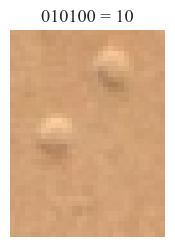

In [170]:
plt.figure(figsize=(2,3))
plt.imshow(ood_X[0])
plt.axis('off')
plt.title(f"{ood_Y_str[0]} = {ood_Y_cat[0].argmax()}")

In [175]:
activs['conv1'].shape

torch.Size([10, 64, 38, 28])

### Intepretability Libraries
NNSight, Transluce

In [104]:
# Compare Separability of Braille Characters, and Braille Dot labels, with library like NNsight

### Feature maps

In [24]:
negative_examples = np.load(os.path.join('..', '..', 'Datasets', 'numpy_datasets', 'neg_samples.npz'))['negative_examples']
negative_examples

array([[[[0.78823529, 0.79215686, 0.76862745],
         [0.78039216, 0.78431373, 0.76078431],
         [0.78039216, 0.78431373, 0.76078431],
         ...,
         [0.77254902, 0.77647059, 0.75294118],
         [0.76862745, 0.77254902, 0.74901961],
         [0.76470588, 0.76862745, 0.74509804]],

        [[0.78823529, 0.79215686, 0.76862745],
         [0.78039216, 0.78431373, 0.76078431],
         [0.78039216, 0.78431373, 0.76078431],
         ...,
         [0.76862745, 0.77254902, 0.74901961],
         [0.76862745, 0.77254902, 0.74901961],
         [0.76470588, 0.76862745, 0.74509804]],

        [[0.78431373, 0.78823529, 0.76470588],
         [0.78431373, 0.78823529, 0.76470588],
         [0.78431373, 0.78823529, 0.76470588],
         ...,
         [0.76862745, 0.77254902, 0.74901961],
         [0.76470588, 0.76862745, 0.74509804],
         [0.76470588, 0.76862745, 0.74509804]],

        ...,

        [[0.79215686, 0.79607843, 0.77254902],
         [0.78823529, 0.79215686, 0.76862745]

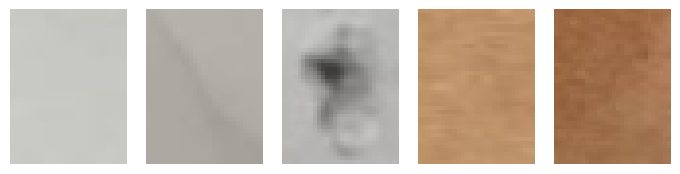

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(7, 3))
for i in range(5):
    axes[i].imshow(negative_examples[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [45]:
ood_Y[:10]

array([[0, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 0]], dtype=int32)

In [51]:
ID_IDX = [0,1,9]
OOD_IDX = [5,1,0]
NEG_IDX = [0,1,3]

viz_samples_X = np.vstack([test_X[ID_IDX], ood_X[OOD_IDX], negative_examples[NEG_IDX]])
viz_samples_Y = np.vstack([test_Y[ID_IDX], ood_Y[OOD_IDX], np.zeros((3, NUM_LABELS)).astype(int)])
viz_samples_Y_cat = np.vstack([test_Y_cat[ID_IDX], ood_Y_cat[OOD_IDX], np.zeros((3, NUM_CLASSES)).astype(int)])
viz_samples_Y_str = np.hstack([test_Y_str[ID_IDX], ood_Y_str[OOD_IDX], ['000000']*3])

viz_samples_Y_cat[6:9, 0] = 1

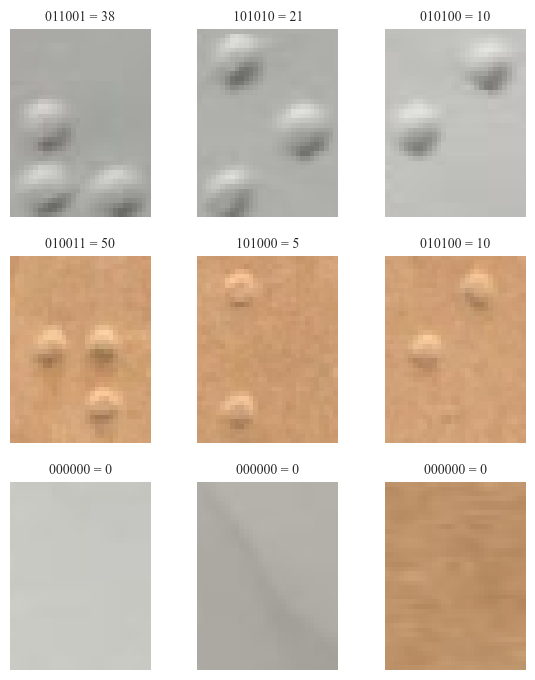

In [52]:
fig, axes = plt.subplots(3, 3, figsize=(6, 7))
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.imshow(viz_samples_X[i])
    ax.axis('off')
    ax.set_title(f"{viz_samples_Y_str[i]} = {viz_samples_Y_cat[i].argmax()}", fontsize=10)
plt.tight_layout()
plt.show()

In [53]:

_, base_mc_acts = base_mc_model.model.forward_with_activs(torch.Tensor(viz_samples_X))
_, base_ml_acts = base_ml_model.model.forward_with_activs(torch.Tensor(viz_samples_X))

In [69]:
base_ml_acts['conv1'].detach().numpy().shape

(9, 24, 30, 30)

(np.float64(-0.5), np.float64(27.5), np.float64(37.5), np.float64(-0.5))

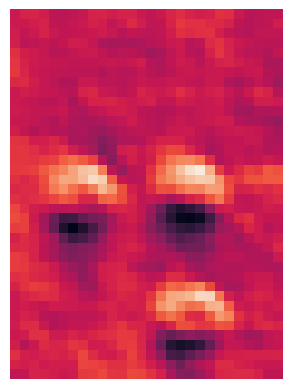

In [97]:
plt.imshow(base_mc_acts['conv1'][3].detach().numpy().mean(axis=0))
plt.axis('off')

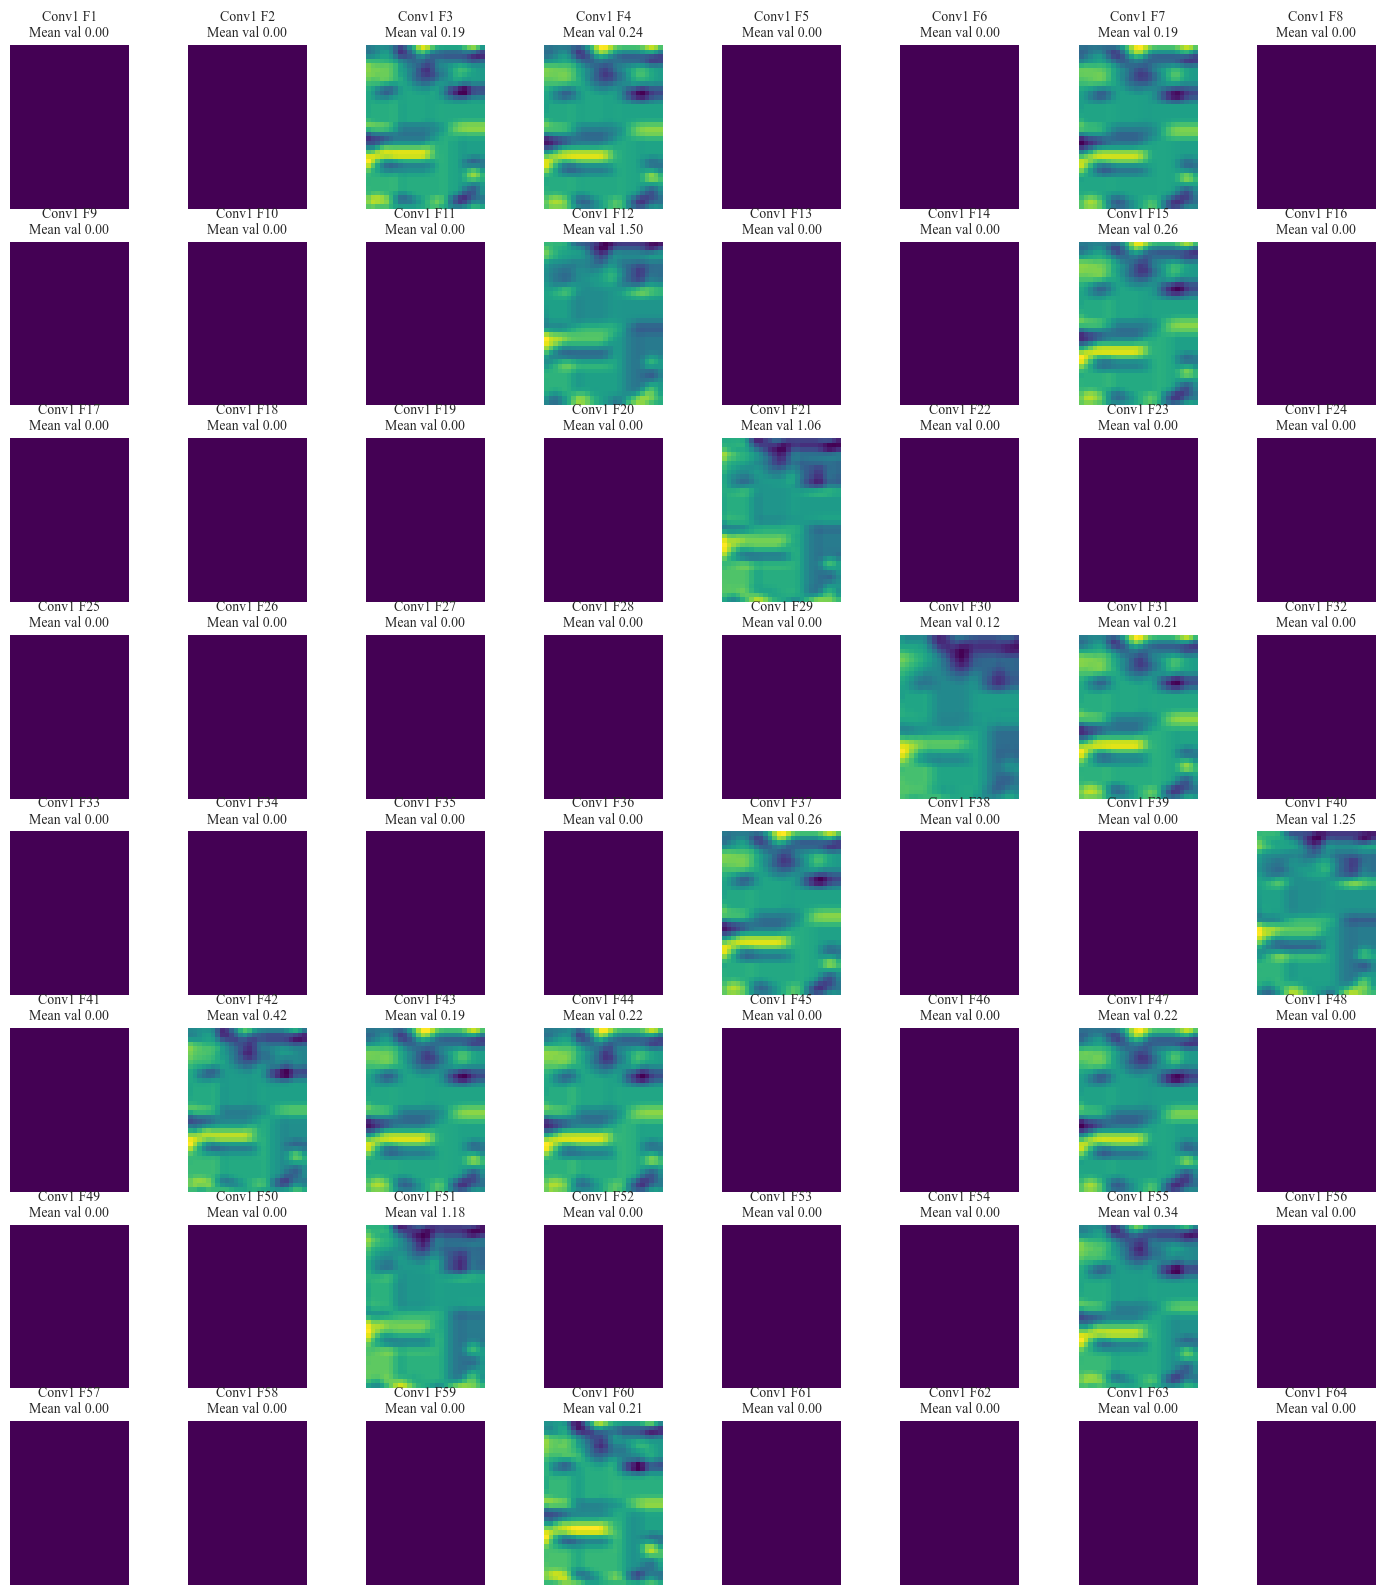

In [102]:


fig, axes = plt.subplots(8, 8, figsize=(18, 20))
for i in range(64):
    ax = axes[i // 8, i % 8]
    filt = base_mc_acts['conv2'][6][i].detach().numpy()
    ax.imshow(filt, cmap='viridis')
    ax.axis('off')
    ax.set_title(f"Conv1 F{i+1}\nMean val {filt.mean():.2f}", fontsize=10)

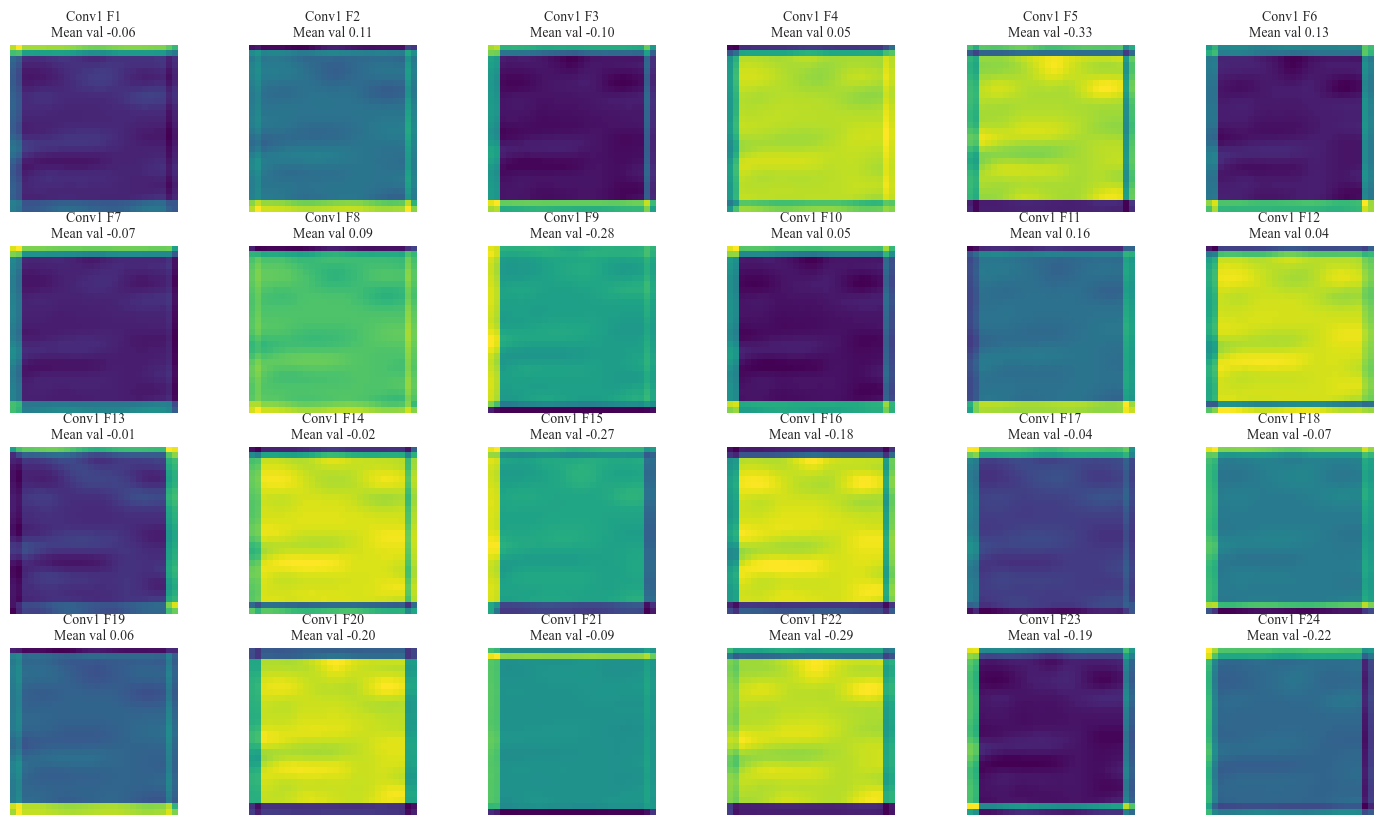

In [103]:


fig, axes = plt.subplots(4, 6, figsize=(18, 10))
for i in range(24):
    ax = axes[i // 6, i % 6]
    filt = base_ml_acts['conv2'][6][i].detach().numpy()
    ax.imshow(filt, cmap='viridis')
    ax.axis('off')
    ax.set_title(f"Conv1 F{i+1}\nMean val {filt.mean():.2f}", fontsize=10)

In [75]:
f"{filt.mean():.2f}"

'0.07'